# Notebook setup

# Import bibliotek

In [2]:
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse

import requests
from PIL import Image
from docling_core.types.doc import ImageRefMode
from docling_core.types.doc.document import DocTagsDocument, DoclingDocument
from mlx_vlm import load, generate
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config, stream_generate

import pandas as pd

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baza danych SQLite

In [3]:
import sqlite3
sqlite_connection = sqlite3.connect("ecclesia.db")
# test połączenia
cursor = sqlite_connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
if tables:
    print("Połączono")
    print("Dostępne tabele:", tables)
else:
    print("Problem z połączeniem")

Połączono
Dostępne tabele: [('dane_hasla',)]


/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/wloclawek_1872/0071.jpg


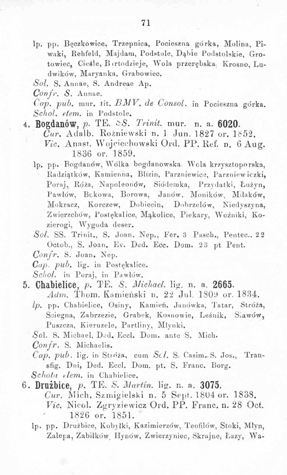

In [4]:
import os
from IPython.display import display
from PIL import Image


ROOT_DIRECTORY = os.path.dirname(os.getcwd())
# walidacje robimy na schematyzmie wloclawek 1872
image_dir = "data/schematyzmy/wloclawek_1872"
ABSOLUTE_IMAGE_DIRECTORY = os.path.join(ROOT_DIRECTORY, image_dir)

image_files = [f for f in os.listdir(ABSOLUTE_IMAGE_DIRECTORY) if f.endswith('.jpg')]

#wczytajmy i wyswietlmy jakis skan
for i, image_file in enumerate(image_files):
    image_path = os.path.join(ABSOLUTE_IMAGE_DIRECTORY, image_file)
    print(image_path)
    with open(image_path, 'rb') as img_file:
         img = Image.open(img_file)
         img = img.resize((img.width // 4, img.height // 4))
         display(img)
    break # konczymy po 5 skanach


# Pre-processing

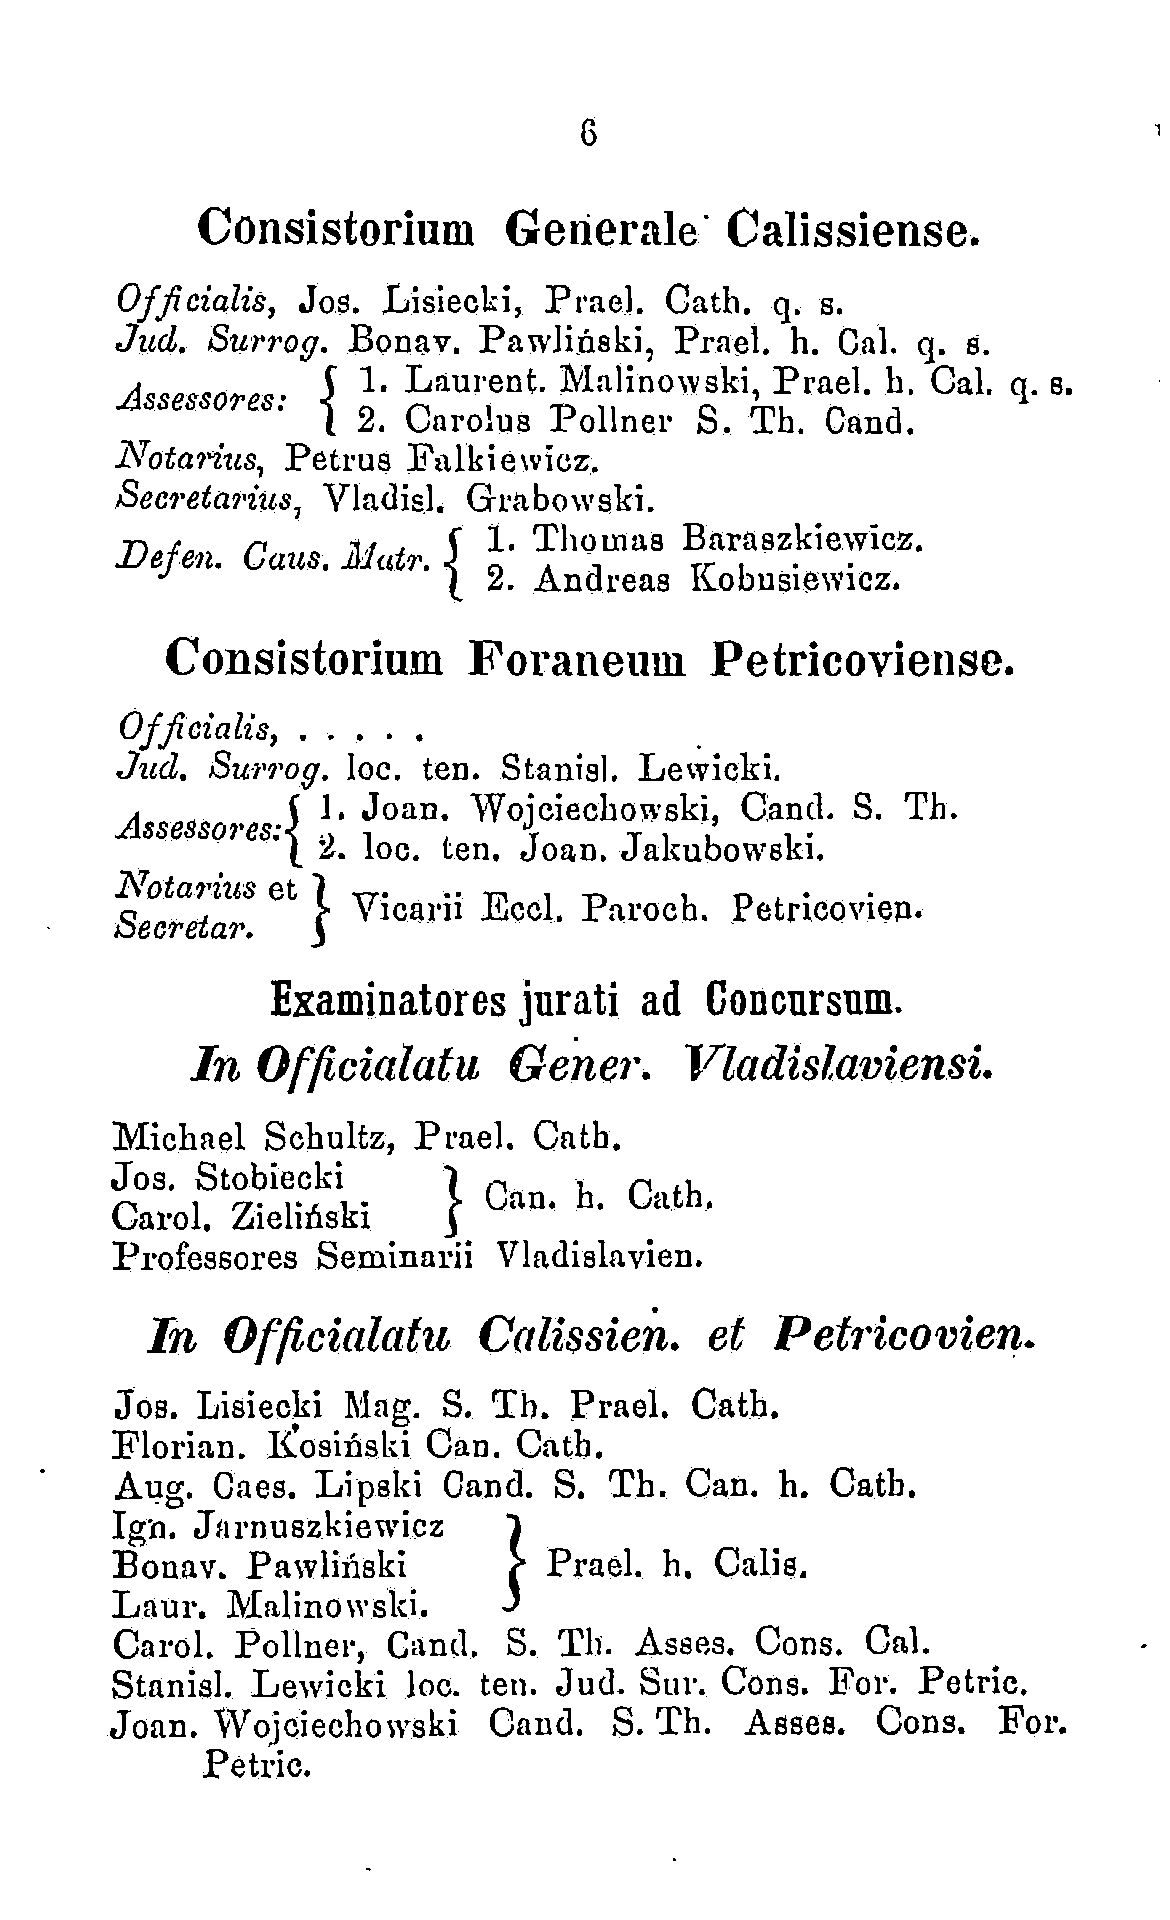

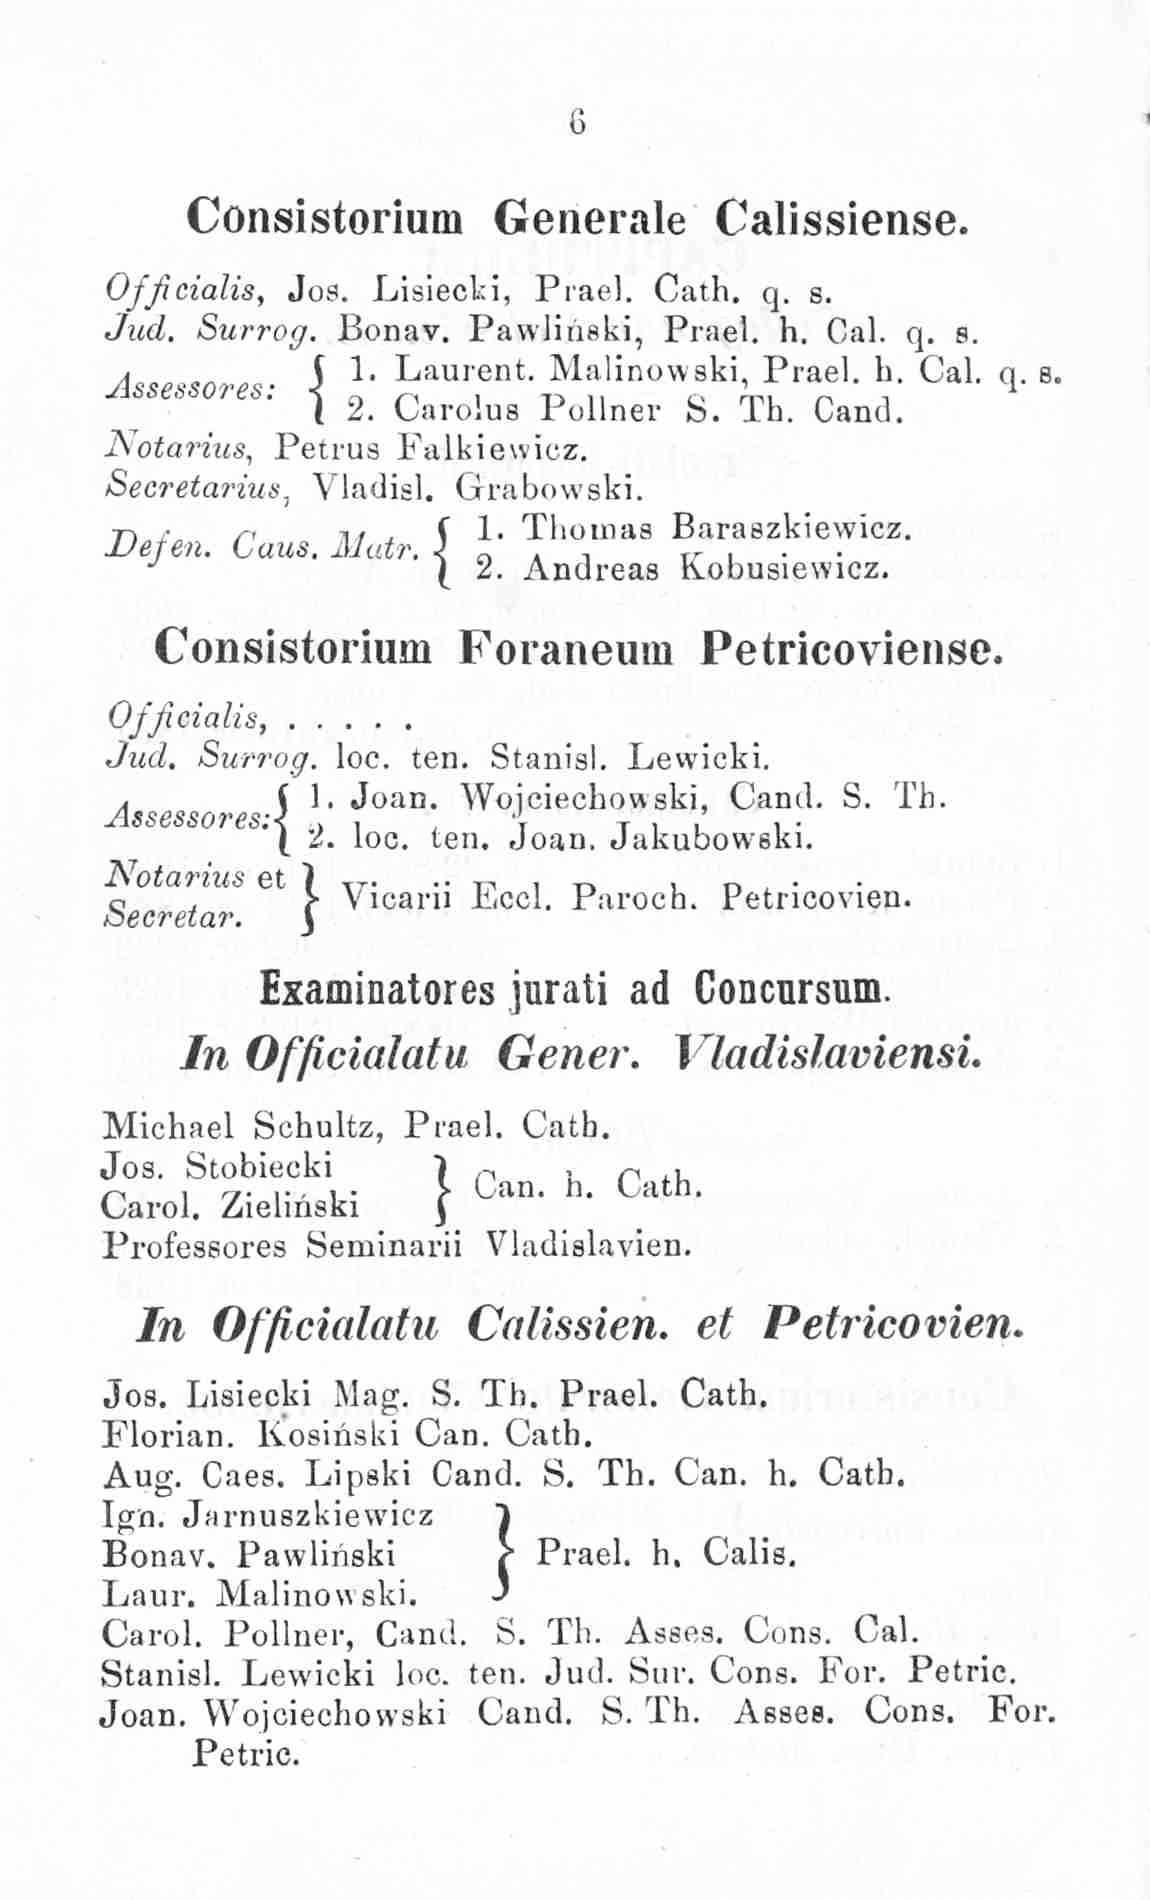

In [5]:
import cv2
import numpy as np
from PIL import Image
import tempfile

def preprocess_for_ocr(pil_image):
    # Step 0: Convert PIL image to OpenCV format
    img = np.array(pil_image)

    # 1. Normalize
    norm_img = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)

    # 2. Resize to improve OCR (if needed)
    height, width = img.shape
    factor = max(1, 1024.0 / width)
    new_size = (int(width * factor), int(height * factor))
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)

    # 3. Noise removal
    img = cv2.fastNlMeansDenoising(img, h=10)

    # 4. Thresholding (adaptive might work better sometimes)
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 2
    )

    # 5. Sharpen (optional, after binarization)
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    img = cv2.filter2D(img, -1, sharpening_kernel)

    # 6. Morphological Opening
    kernel = np.ones((2, 2), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # 7. Add white border
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    # Final: Convert back to PIL
    final_pil = Image.fromarray(img)
    return final_pil

# Load sample image
sample_image_path = "/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/wloclawek_1872/0006.jpg"
sample_image = Image.open(sample_image_path)

# Process the sample
processed_image = preprocess_for_ocr(sample_image)
display(processed_image)
processed_image.save("processed_image.png")
display(sample_image)

In [6]:
import pandas as pd

# wczytajmy dane z bazy danych do dataframe
query = "SELECT * FROM dane_hasla WHERE skany = 'wloclawek_1872'"
skany_df = pd.read_sql_query(query, sqlite_connection)

# wyświetlmy dane z dataframe
skany_df

id    dekanat   diecezja      parafia      miejsce  \
0    26291  Włocławek  Włocławek    Włocławek    Włocławek   
1    26292  Włocławek  Włocławek      Boniewo      Boniewo   
2    26293  Włocławek  Włocławek       Brześć       Brześć   
3    26294  Włocławek  Włocławek       Choceń       Choceń   
4    26295  Włocławek  Włocławek      Chodecz      Chodecz   
..     ...        ...        ...          ...          ...   
333  26627    Radomsk  Włocławek    Rzejowice    Rzejowice   
334  26628    Radomsk  Włocławek  Sulmierzyce  Sulmierzyce   
335  26629    Radomsk  Włocławek  Wielgomłyny  Wielgomłyny   
336  26630    Radomsk  Włocławek      Wiewiec      Wiewiec   
337  26631    Radomsk  Włocławek        Żytno        Żytno   

            typ_obiektu                                           wezwanie  \
0    kościół parafialny                                     Jan Chrzciciel   
1    kościół parafialny               Nawiedzenie Najświętszej Maryi Panny   
2    kościół parafialny                         Stanisław Biskup Męczennik   
3    kościół parafialny                                          Idzi Opat   
4    kościół parafialny                                     Dominik Guzmán   
..                  ...                                                ...   
333  kościół parafialny                                        Wszyscy Św.   
334  kościół parafialny                             Erazm Biskup Męczennik   
335  kościół parafialny                         Stanisław Biskup Męczennik   
336  kościół parafialny                                      Marcin Biskup   
337  kościół parafialny  Najświętsza Maria Panna Szkaplerzna, Wawrzynie...   

          wezwanie_par material_typ  \
0    [brak informacji]           mr   
1    [brak informacji]           dr   
2    [brak informacji]           mr   
3    [brak informacji]           dr   
4    [brak informacji]           mr   
..                 ...          ...   
333                              dr   
334                              mr   
335                              mr   
336                              mr   
337                              dr   

                                              the_geom strona_p strona_k  \
0    MULTIPOLYGON (((36.253799987793 2317.444700012...       10       10   
1    MULTIPOLYGON (((40.233799987793006 2319.132700...       11       11   
2    MULTIPOLYGON (((40.217799987793 2318.020700012...       11       11   
3    MULTIPOLYGON (((40.237799987793 2316.304700012...       11       11   
4    MULTIPOLYGON (((40.205799987793 2315.248700012...       11       12   
..                                                 ...      ...      ...   
333  MULTIPOLYGON (((380.27599996948 2315.658999992...       96       96   
334  MULTIPOLYGON (((380.29599996948 2314.318999992...       96       97   
335  MULTIPOLYGON (((384.24799996948 2317.766999992...       97       97   
336  MULTIPOLYGON (((384.25599996948006 2315.862999...       96       96   
337  MULTIPOLYGON (((384.29999996948 2314.510999992...       97       98   

              skany faksymile  
0    wloclawek_1872            
1    wloclawek_1872            
2    wloclawek_1872            
3    wloclawek_1872            
4    wloclawek_1872            
..              ...       ...  
333  wloclawek_1872            
334  wloclawek_1872            
335  wloclawek_1872            
336  wloclawek_1872            
337  wloclawek_1872            

[338 rows x 14 columns]

## Model OCR

### SmolDocling

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 147367.44it/s]

Processing 0011.jpg


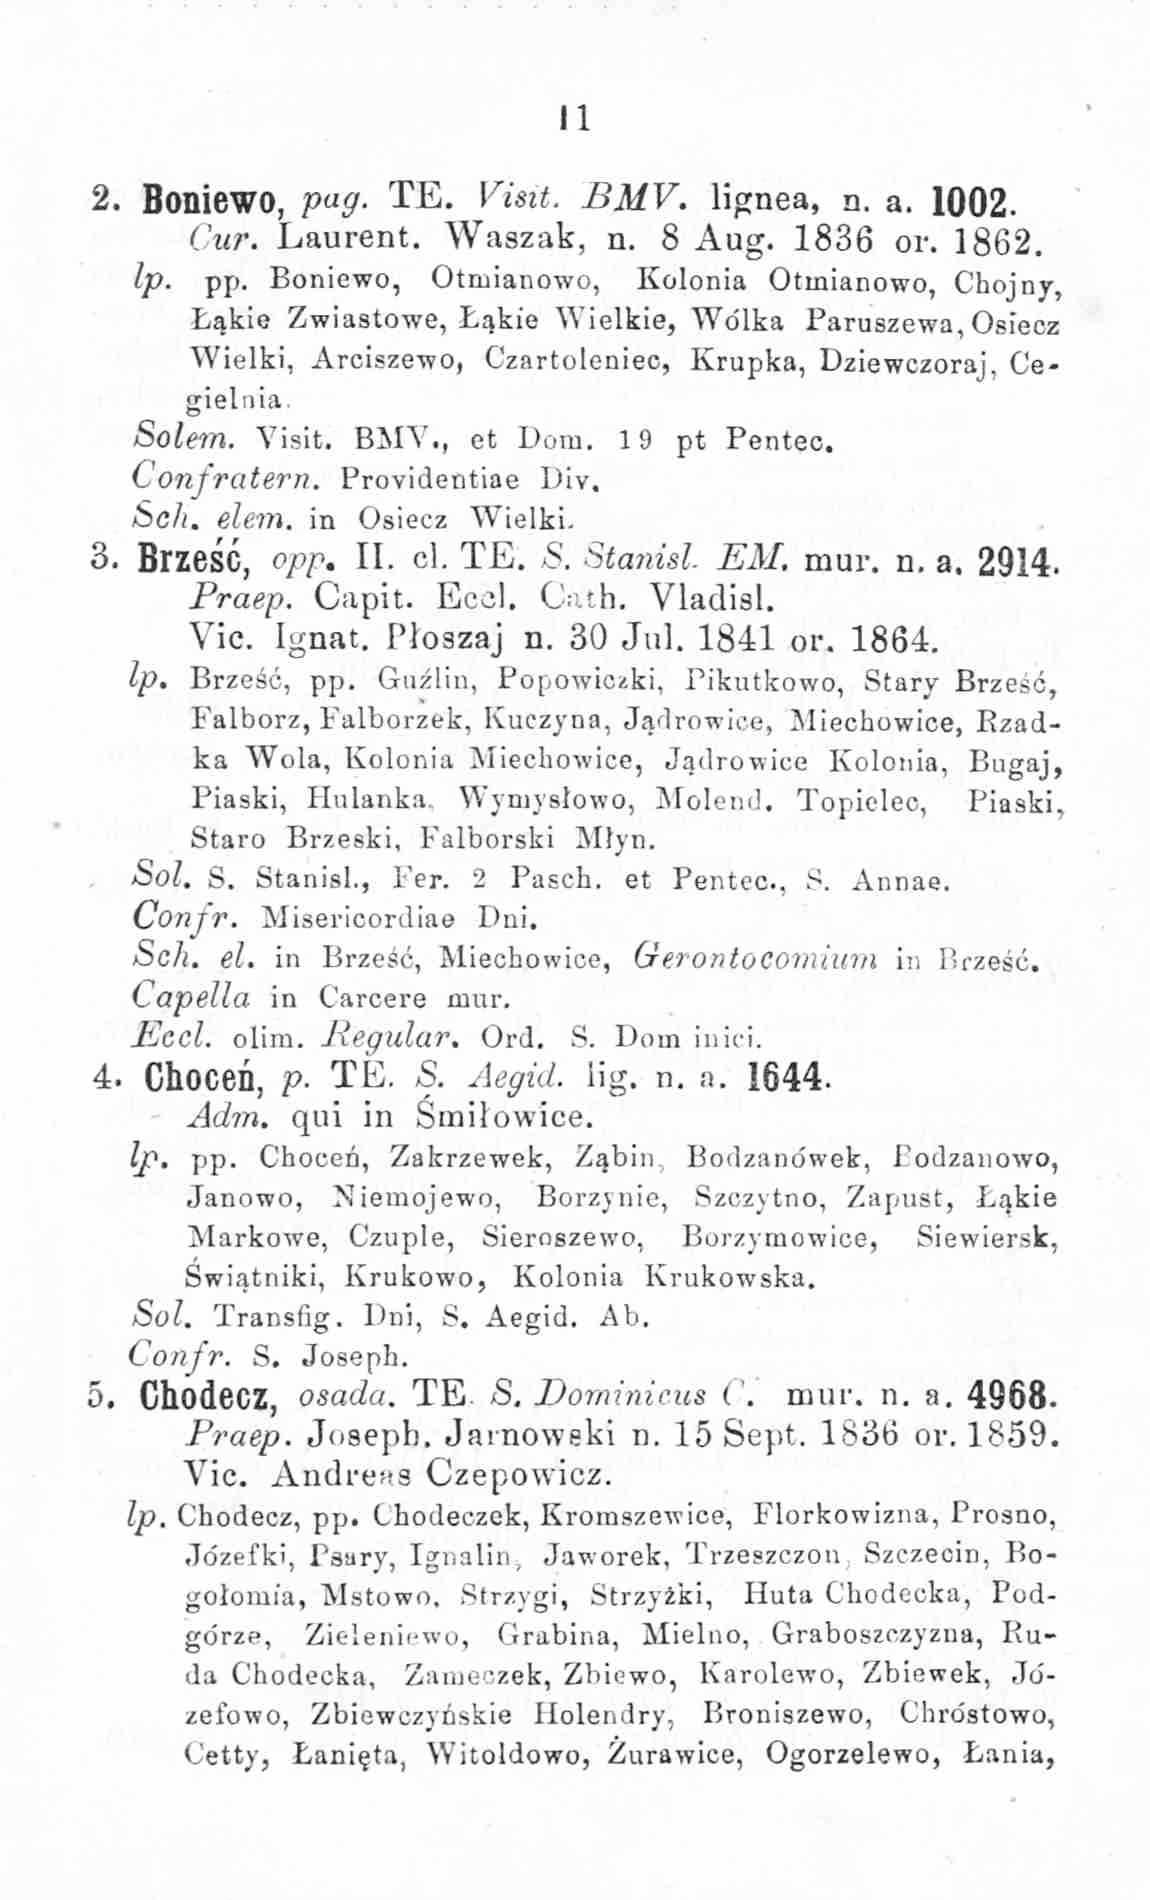

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


 <doctag><page_header><loc_243><loc_26><loc_257><loc_35>11</page_header>
<section_header_level_1><loc_39><loc_47><loc_443><loc_61>2. Boniewo, pug. TE. Visit. BMV. lignea, n. a. 1002.</section_header_level_1>
<text><loc_54><loc_60><loc_458><loc_110>Cur. Laurent. Waszak, n. 8 Aug. 1836 or. 1862. lp. pp. Boniewo, Otmanowo, Kolonia Otmanowo, Chojny, Lakie Zwiastowe, Eakie Wielkie, Wolka Paruszewa, Osiecz Wielki, Arciszewo, Czartoleniec, Krupka, Dziewczoraj, Ce- gielnia.</text>
<text><loc_54><loc_110><loc_364><loc_124>Solem. Visit. BMV., et Dom. 19 pt Pentecost.</text>
<text><loc_54><loc_123><loc_257><loc_139>Confratern. Providentiae Div. Sch. elem. in Osiecz Wielki.</text>
<unordered_list><list_item><loc_39><loc_140><loc_462><loc_163>3. Brzesc, opp. II. cl. TE. S. Stanisl. EM. mur. n. a. 2914. Praep. Capit. Ecel. Cath. Vladisil.</list_item>
</unordered_list>
<text><loc_54><loc_163><loc_410><loc_177>Vic. Ignat. Ploszaj n. 30 Jul. 1841 or. 1864.</text>
<unordered_list><list_item><loc_54><loc

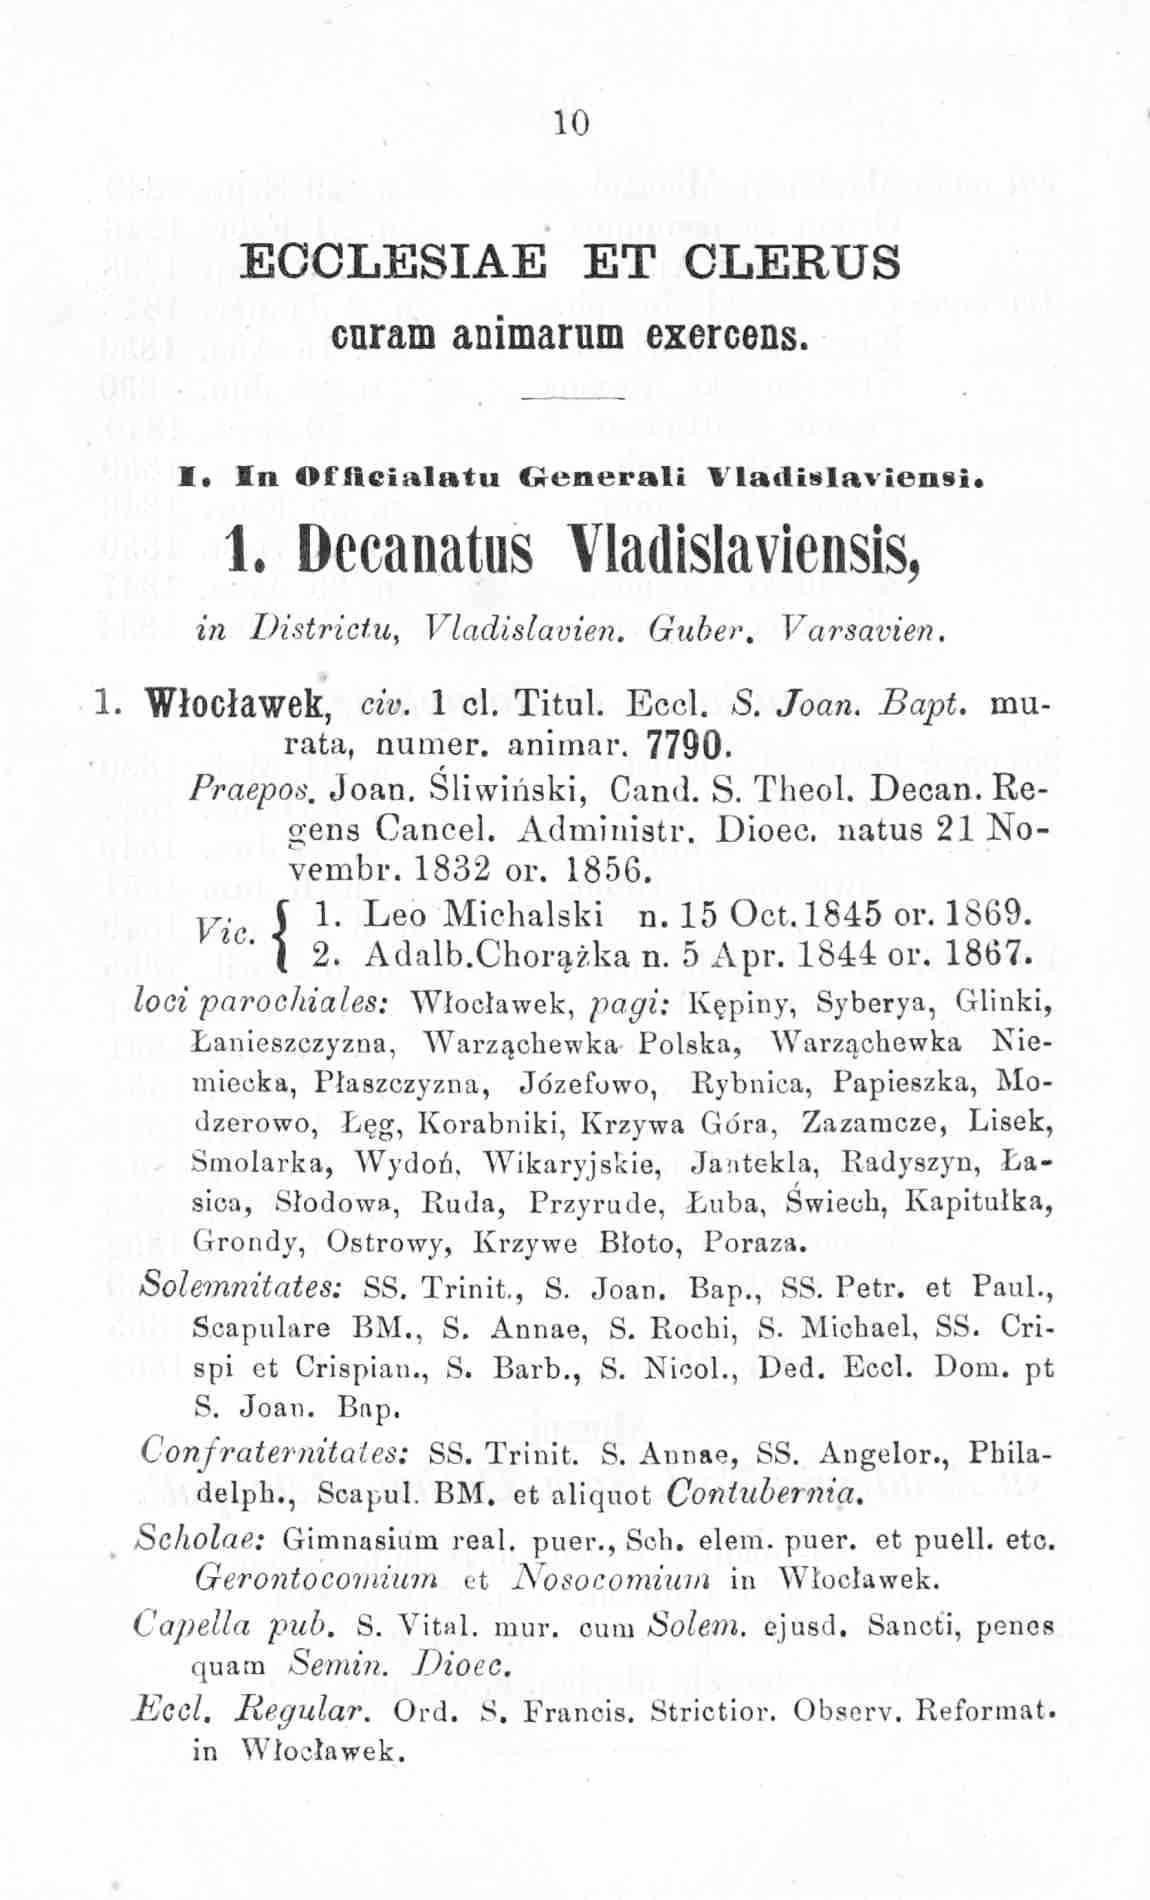

 <doctag><page_header><loc_239><loc_28><loc_256><loc_37>10</page_header>
<section_header_level_1><loc_102><loc_62><loc_393><loc_75>ECOLESIAE ET CLERUS</section_header_level_1>
<section_header_level_1><loc_141><loc_82><loc_352><loc_93>curam animarum excerces.</section_header_level_1>
<section_header_level_1><loc_73><loc_120><loc_431><loc_132>1. In Officiatu Generali Vadislavienis.</section_header_level_1>
<section_header_level_1><loc_96><loc_135><loc_402><loc_152>1. Decanusus Vladislavienis,</section_header_level_1>
<text><loc_83><loc_160><loc_413><loc_171>in Districtu, Vladislavien. Guber. Varsavien.</text>
<unordered_list><list_item><loc_41><loc_179><loc_457><loc_200>1. Wioclawek, ci. 1 cl. Titul. Ecl. S. Joan. Bapt. mu- rata, numer. animar. 7790.</list_item>
</unordered_list>
<text><loc_83><loc_202><loc_457><loc_234>Praepos. Joan. Śliwiński, Cand. S. Theol. Decan. Re- gens Cancel. Admiusrtr. Dioc. natus 21 No- vembr. 1832 or. 1856.</text>
<text><loc_83><loc_236><loc_452><loc_256>Vic.

AttributeError: 'tuple' object has no attribute 'values'

In [40]:
from typing import List
import re

class SmolDoclingOCR:
    def __init__(self, model_path, prompt:str = None, verbose:bool = False):
        self.model, self.processor = load(model_path)
        self.config = load_config(model_path)
        self.prompt = "Convert this page to docling." if prompt is None else prompt
        self.formatted_prompt = apply_chat_template(self.processor, self.config, self.prompt, num_images=1)
        self.verbose = verbose
        
        

    def _extract_page_number(self, page_header: str) -> int:
        pattern = r'<page_header>.*?>(\d+)<\/page_header>'
        match = re.search(pattern, page_header)
        if match:
            return int(match.group(1))
        else:
            return None

    def ocr_schematism_page(self, schematism_page: Image.Image) -> DoclingDocument:
        output = ""
        for token in stream_generate(
            self.model, self.processor, self.formatted_prompt, [schematism_page], max_tokens=8096, verbose=self.verbose
        ):
            output += token.text
            print(token.text, end="")
            if "</doctag>" in token.text:
                break
                
        print(f"\nProcessed {image_file}\n")

        return output
    def ocr(self, source_directory: str) -> DoclingDocument:
        scans = []
        ocr_results = {}
        for image_file in sorted(os.listdir(source_directory)):
            if not image_file.endswith('.jpg'):
                continue
            if self.verbose:
                print(f"Processing {image_file}")
            schematism_page_path = os.path.join(source_directory, image_file)
            with Image.open(schematism_page_path) as image:
                #preprocessed = preprocess_for_ocr(image)
                preprocessed = image
                display(preprocessed)
                ocr_result = self.ocr_schematism_page(preprocessed)
                page_number = self._extract_page_number(ocr_result)
                scans.append(preprocessed)
                ocr_results[page_number] = ocr_result


        #sortowanie ocr_results po kluczach zatrzymujac referencje do scans
        sorted_ocr_results, sorted_scans = zip(*sorted(zip(ocr_results.keys(), scans)))

        print(ocr_results)
        doctags_doc = DocTagsDocument.from_doctags_and_image_pairs(sorted_ocr_results.values(), sorted_scans)
        doc = DoclingDocument(name=os.path.basename(f"{source_directory}"))
        doc.load_from_doctags(doctags_doc)
        return doc
    

smol_docling = SmolDoclingOCR(model_path="ds4sd/SmolDocling-256M-preview-mlx-bf16", verbose=True)
docling_orc_resutl: DoclingDocument = smol_docling.ocr("/Users/user/Projects/ecclesiasticalOCR/research/sample")
                

In [17]:
import base64
from io import BytesIO
from PIL import Image, ImageDraw
from collections import defaultdict

def render_bounding_boxes(data):
    # Group bounding boxes by page number
    page_bboxes = defaultdict(list)
    
    # Collect all bounding boxes from texts
    for text in data['texts']:
        for prov in text.get('prov', []):
            page_no = str(prov['page_no'])
            bbox = prov['bbox']
            page_bboxes[page_no].append(bbox)
    
    # Process each page
    results = {}
    for page_key, page_info in data['pages'].items():
        # Decode base64 image
        image_uri = page_info['image']['uri']
        base64_data = image_uri.split(',', 1)[1]
        image_data = base64.b64decode(base64_data)
        image = Image.open(BytesIO(image_data))
        
        # Draw bounding boxes
        draw = ImageDraw.Draw(image)
        for bbox in page_bboxes.get(page_key, []):
            left = bbox['l']
            top = bbox['t']
            right = bbox['r']
            bottom = bbox['b']
            
            # Draw rectangle
            draw.rectangle(
                [(left, top), (right, bottom)],
                outline="red",
                width=2
            )
        
        # Store result (you could save to file instead)
        output_buffer = BytesIO()
        image.save(output_buffer, format="PNG")
        results[page_key] = output_buffer.getvalue()
    
    return results

# Usage example:
rendered_pages = render_bounding_boxes(docling_orc_resutl.export_to_dict())
# To display an image:
Image.open(BytesIO(rendered_pages['1'])).show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'schema_name': 'DoclingDocument',
 'version': '1.3.0',
 'name': 'sample',
 'furniture': {'self_ref': '#/furniture',
  'children': [],
  'content_layer': 'furniture',
  'name': '_root_',
  'label': 'unspecified'},
 'body': {'self_ref': '#/body',
  'children': [{'$ref': '#/texts/0'},
   {'$ref': '#/texts/1'},
   {'$ref': '#/texts/2'},
   {'$ref': '#/texts/3'},
   {'$ref': '#/texts/4'},
   {'$ref': '#/groups/0'},
   {'$ref': '#/texts/6'},
   {'$ref': '#/groups/1'},
   {'$ref': '#/texts/8'},
   {'$ref': '#/texts/9'},
   {'$ref': '#/texts/10'},
   {'$ref': '#/groups/2'},
   {'$ref': '#/texts/15'},
   {'$ref': '#/groups/3'},
   {'$ref': '#/texts/19'},
   {'$ref': '#/texts/20'},
   {'$ref': '#/texts/21'},
   {'$ref': '#/texts/22'},
   {'$ref': '#/texts/23'},
   {'$ref': '#/texts/24'},
   {'$ref': '#/groups/4'},
   {'$ref': '#/texts/26'},
   {'$ref': '#/texts/27'},
   {'$ref': '#/texts/28'},
   {'$ref': '#/texts/29'},
   {'$ref': '#/texts/30'},
   {'$ref': '#/texts/31'},
   {'$ref': '#/texts/
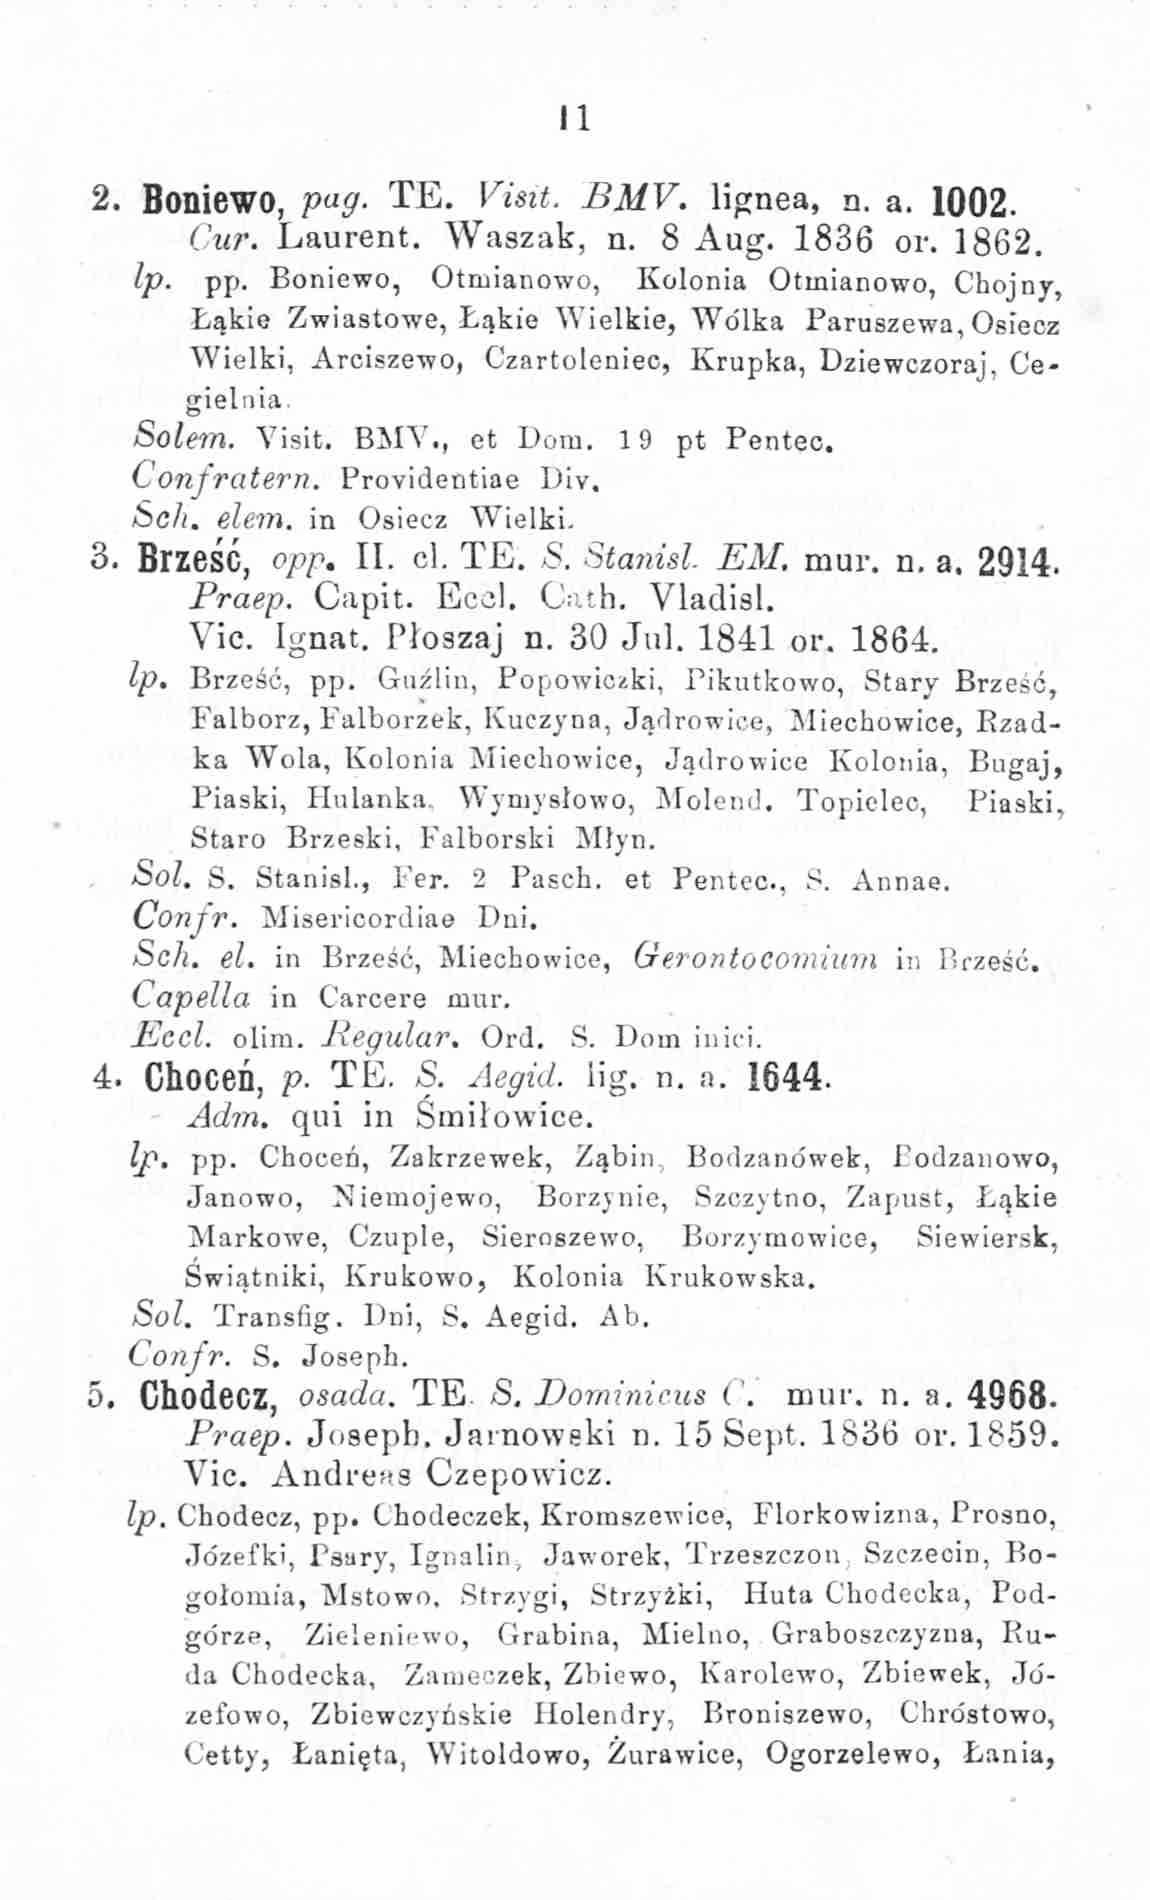
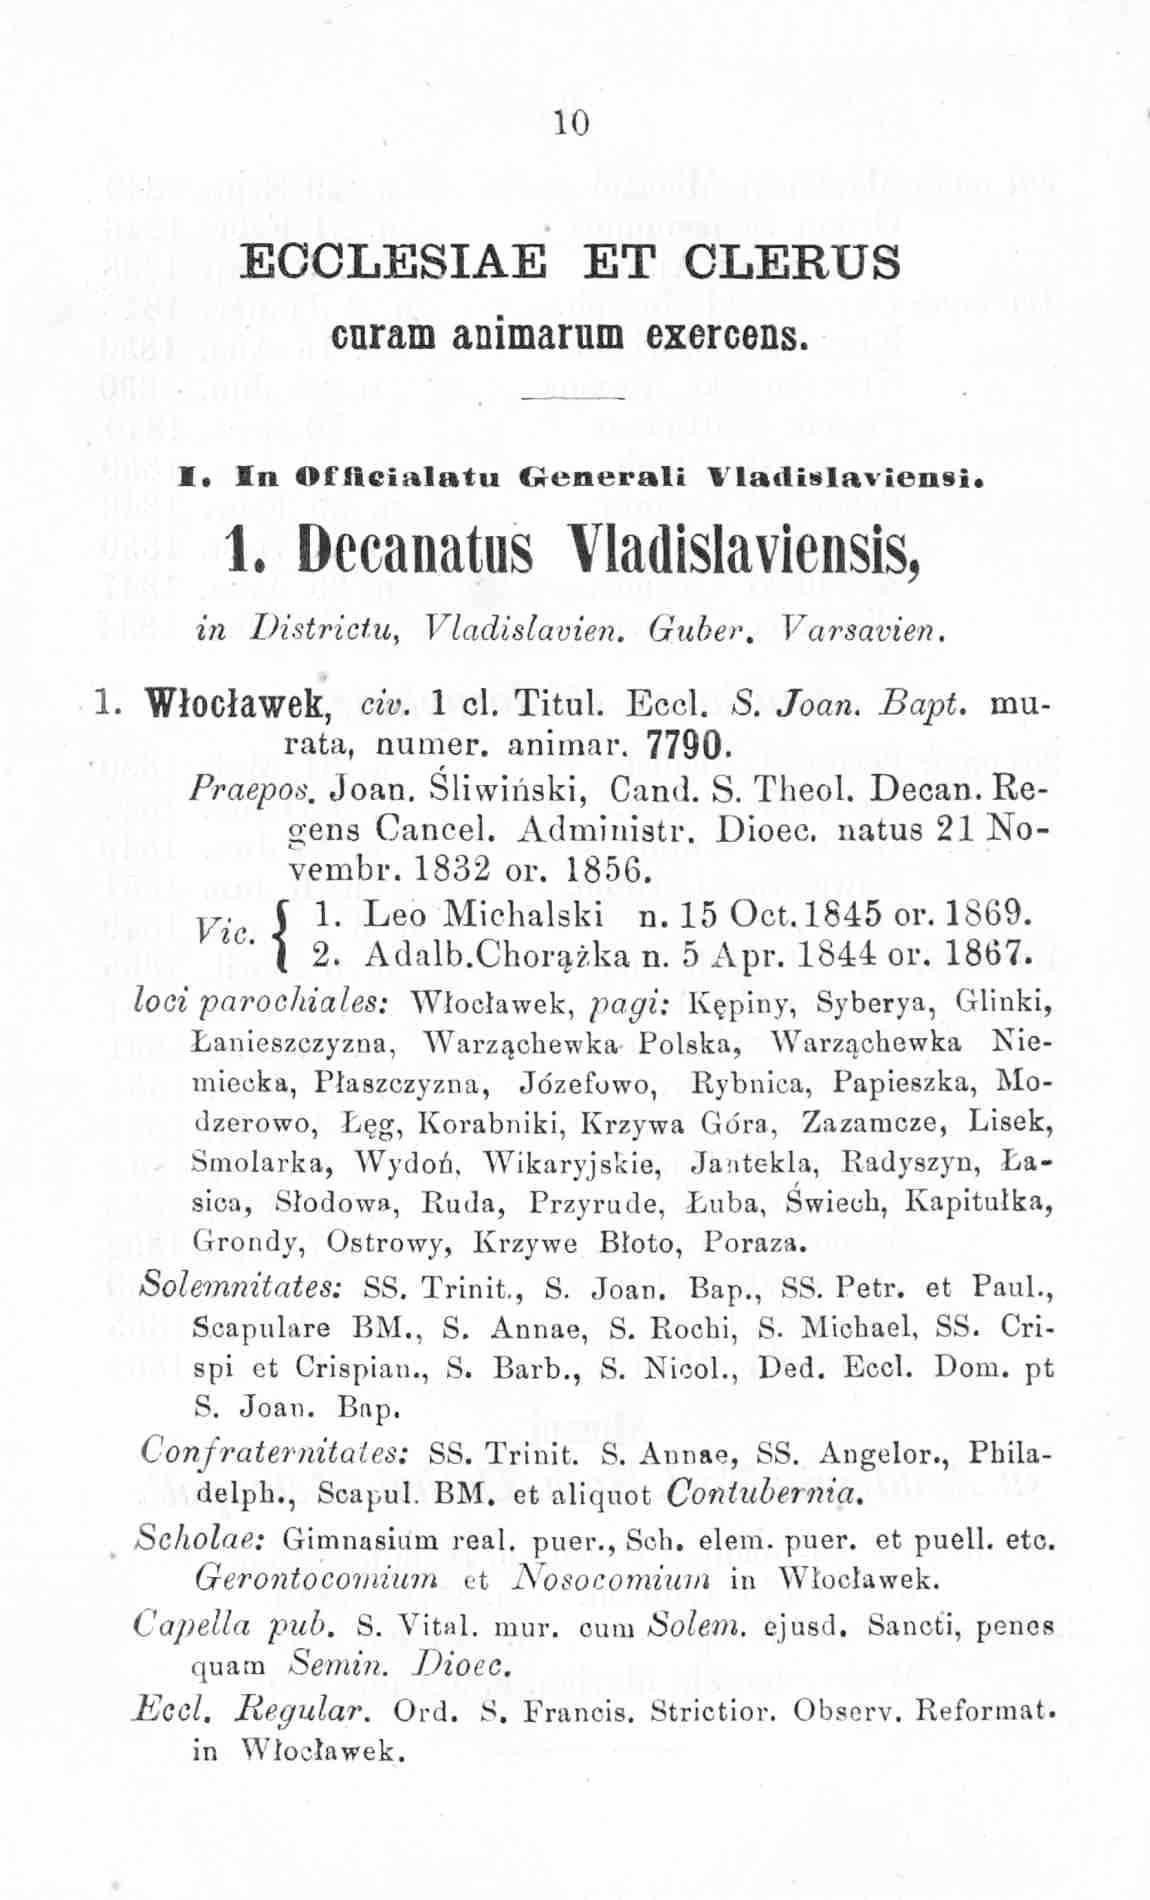

In [18]:
docling_orc_resutl.export_to_dict()

In [19]:
page_headers = [text for text in docling_orc_resutl.texts if text.label == 'page_header']
for header in page_headers:
    print(header.text)

11
10


In [37]:
import re
sample =  [' <doctag><page_header><loc_243><loc_26><loc_257><loc_35>11</page_header>\n<section_header_level_1><loc_39><loc_47><loc_443><loc_61>2. Boniewo, pug. TE. Visit. BMV. lignea, n. a. 1002.</section_header_level_1>\n<text><loc_54><loc_60><loc_458><loc_110>Cur. Laurent. Waszak, n. 8 Aug. 1836 or. 1862. lp. pp. Boniewo, Otmanowo, Kolonia Otmanowo, Chojny, Lakie Zwiastowe, Eakie Wielkie, Wolka Paruszewa, Osiecz Wielki, Arciszewo, Czartoleniec, Krupka, Dziewczoraj, Ce- gielnia.</text>\n<text><loc_54><loc_110><loc_364><loc_124>Solem. Visit. BMV., et Dom. 19 pt Pentecost.</text>\n<text><loc_54><loc_123><loc_257><loc_139>Confratern. Providentiae Div. Sch. elem. in Osiecz Wielki.</text>\n<unordered_list><list_item><loc_39><loc_140><loc_462><loc_163>3. Brzesc, opp. II. cl. TE. S. Stanisl. EM. mur. n. a. 2914. Praep. Capit. Ecel. Cath. Vladisil.</list_item>\n</unordered_list>\n<text><loc_54><loc_163><loc_410><loc_177>Vic. Ignat. Ploszaj n. 30 Jul. 1841 or. 1864.</text>\n<unordered_list><list_item><loc_54><loc_176><loc_462><loc_225>lp. Brzesc, pp. Guzlin, Popowicki, Pikutkowo, Stary Brzesc, Falborz, Falborzek, Kuczyna, Jadrowice, Miechowice, Rzadka Wola, Kolonia Miechowice, Jadrowice Kolonia, Bugaj, Piaski, Hulanka, Wynysłowo, Molend. Topielec, Piaski, Staro Brzeski, Falborski Młyn.</list_item>\n</unordered_list>\n<text><loc_54><loc_225><loc_415><loc_239>Sol. S. Stanisl., Fer. 2 Pasch. et Pentecost, S. Annae.</text>\n<text><loc_54><loc_238><loc_238><loc_249>Confr. Misericordiae Dni.</text>\n<text><loc_54><loc_248><loc_454><loc_263>Sch. el. in Brzesc, Miechowice, Gerontocomium in Brzesc. Capella in Carcere mur.</text>\n<unordered_list><list_item><loc_54><loc_263><loc_333><loc_277>Ecl. olim. Regular. Ord. S. Dom inici.</list_item>\n<list_item><loc_39><loc_277><loc_364><loc_292>4. Chocen, p. T.S. Aegid. lig. n. a. 1644.</list_item>\n<list_item><loc_54><loc_291><loc_257><loc_304>Adm. qui in Smilowice.</list_item>\n<list_item><loc_54><loc_303><loc_462><loc_342>lp. pp. Chocen, Zakrzewek, Zabin, Bodzanówek, Eodzanowo, Janowo, Niemojewo, Borzynie, Szczynto, Zapust, Łakie Markowe, Czuple, Sieroszewo, Borzynowice, Siewiersk, światniki, Krukowo, Kolonia Krukowska.</list_item>\n</unordered_list>\n<text><loc_54><loc_342><loc_286><loc_356>Sol. Transfig. Dni, S. Aegid. Ab.</text>\n<unordered_list><list_item><loc_39><loc_356><loc_178><loc_368>Confr. S. Joseph.</list_item>\n<list_item><loc_39><loc_367><loc_462><loc_391>5. Chodecz, osada. TE. S. Dominicus C. mur. n. a. 4968. Praep. Josepb. Jarnowski n. 15 Sept. 1836 or. 1859.</list_item>\n<list_item><loc_54><loc_390><loc_462><loc_469>Vic. Andreas Czepowicz. lp. Chodecz, pp. Chodeczek, Kromszewice, Florkowizna, Proso, Józefki, Pary, Ignalin, Jaworek, Trzeszczon, Szczecin, Bo- gołomia, Mstowo. Strzygi, Strzyki, Huta Chodecka, Pod- górze, Zieleniewo, Grabina, Mielno, Graboszczyzna, Ru- da Chodecka, Zaneczek, Zbiewo, Karolewo, Zbiewek, Jó- zefowo, Zbiewczyńskie Holendry, Broniszewo, Chrośtowo, Cetty, Lanicta, Witoldowo, Żurawice, Ogorzelewo, Żania,</list_item>\n</unordered_list>\n</doctag>', ' <doctag><page_header><loc_239><loc_28><loc_256><loc_37>10</page_header>\n<section_header_level_1><loc_102><loc_62><loc_393><loc_75>ECOLESIAE ET CLERUS</section_header_level_1>\n<section_header_level_1><loc_141><loc_82><loc_352><loc_93>curam animarum excerces.</section_header_level_1>\n<section_header_level_1><loc_73><loc_120><loc_431><loc_132>1. In Officiatu Generali Vadislavienis.</section_header_level_1>\n<section_header_level_1><loc_96><loc_135><loc_402><loc_152>1. Decanusus Vladislavienis,</section_header_level_1>\n<text><loc_83><loc_160><loc_413><loc_171>in Districtu, Vladislavien. Guber. Varsavien.</text>\n<unordered_list><list_item><loc_41><loc_179><loc_457><loc_200>1. Wioclawek, ci. 1 cl. Titul. Ecl. S. Joan. Bapt. mu- rata, numer. animar. 7790.</list_item>\n</unordered_list>\n<text><loc_83><loc_202><loc_457><loc_234>Praepos. Joan. Śliwiński, Cand. S. Theol. Decan. Re- gens Cancel. Admiusrtr. Dioc. natus 21 No- vembr. 1832 or. 1856.</text>\n<text><loc_83><loc_236><loc_452><loc_256>Vic. 1. Leo Michalski n. 15 Oct. 1845 or. 1869.</text>\n<text><loc_49><loc_257><loc_457><loc_331>loci parocliales: Włocławek, pagi: Kepiny, Syberya, Glinki, Lanieszczyzna, Warząchewka Polska, Warząchewka Nie- miecka, Plaszczyzna, Józefowo, Rybnica, Papieszka, Mo- dzerowo, Leg, Korabniki, Krzywa Góra, Zazamczze, Lisek, Smolarka, Wydoł, Wikaryjskie, Jantekla, Radyszyn, La- sica, Stodowa, Ruda, Przyrude, Łuba, Świech, Kapitulka, Grondy, Ostrowy, Krzywe Bloto, Poraza.</text>\n<text><loc_49><loc_333><loc_457><loc_375>Solemnitates: S. S. Trinit., S. Joan. Bap., SS. Petr. et Paul., Scapulare BM., S. Annae, S. Rochi, S. Michael, SS. Cri- spi et Crispan., S. Barb., S. Nicol., Ded. Eecl. Dom. pt S. Joan. Bap.</text>\n<text><loc_59><loc_377><loc_457><loc_398>Confraternitates: SS. Trinit. S. Annae, SS. Angelor, Phila- delph., Scapul. BM. et aliquot Contubernia.</text>\n<text><loc_59><loc_400><loc_457><loc_419>Scholae: Gimnasium real. puer., Sch. elem. puer. et puell. etc. Gerontoconium et Nosocomium in Włocławek.</text>\n<text><loc_59><loc_422><loc_457><loc_443>Capella pub. S. Vital. mur. cum Solem, ejusd. Sancti, penes quam Semin. Dioc.</text>\n<text><loc_59><loc_445><loc_461><loc_465>Eecl. Regular. Ord. S. Francis. Strictior. Observ. Reformat. in Włocławek.</text>\n</doctag>']

for page in sample:
    print(page)

 <doctag><page_header><loc_243><loc_26><loc_257><loc_35>11</page_header>
<section_header_level_1><loc_39><loc_47><loc_443><loc_61>2. Boniewo, pug. TE. Visit. BMV. lignea, n. a. 1002.</section_header_level_1>
<text><loc_54><loc_60><loc_458><loc_110>Cur. Laurent. Waszak, n. 8 Aug. 1836 or. 1862. lp. pp. Boniewo, Otmanowo, Kolonia Otmanowo, Chojny, Lakie Zwiastowe, Eakie Wielkie, Wolka Paruszewa, Osiecz Wielki, Arciszewo, Czartoleniec, Krupka, Dziewczoraj, Ce- gielnia.</text>
<text><loc_54><loc_110><loc_364><loc_124>Solem. Visit. BMV., et Dom. 19 pt Pentecost.</text>
<text><loc_54><loc_123><loc_257><loc_139>Confratern. Providentiae Div. Sch. elem. in Osiecz Wielki.</text>
<unordered_list><list_item><loc_39><loc_140><loc_462><loc_163>3. Brzesc, opp. II. cl. TE. S. Stanisl. EM. mur. n. a. 2914. Praep. Capit. Ecel. Cath. Vladisil.</list_item>
</unordered_list>
<text><loc_54><loc_163><loc_410><loc_177>Vic. Ignat. Ploszaj n. 30 Jul. 1841 or. 1864.</text>
<unordered_list><list_item><loc_54><loc

('schema_name', 'DoclingDocument')
-----
('version', '1.3.0')
-----
('name', 'sample')
-----
('origin', None)
-----
('furniture', GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>))
-----
('body', GroupItem(self_ref='#/body', parent=None, children=[RefItem(cref='#/texts/0'), RefItem(cref='#/texts/1'), RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/groups/0'), RefItem(cref='#/texts/6'), RefItem(cref='#/groups/1'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/groups/2'), RefItem(cref='#/texts/15'), RefItem(cref='#/groups/3'), RefItem(cref='#/texts/19'), RefItem(cref='#/texts/20'), RefItem(cref='#/texts/21'), RefItem(cref='#/texts/22'), RefItem(cref='#/texts/23'), RefItem(cref='#/texts/24'), RefItem(cref='#/groups/4'), RefItem(cref='#/texts/26'), RefItem(cref='#/tex
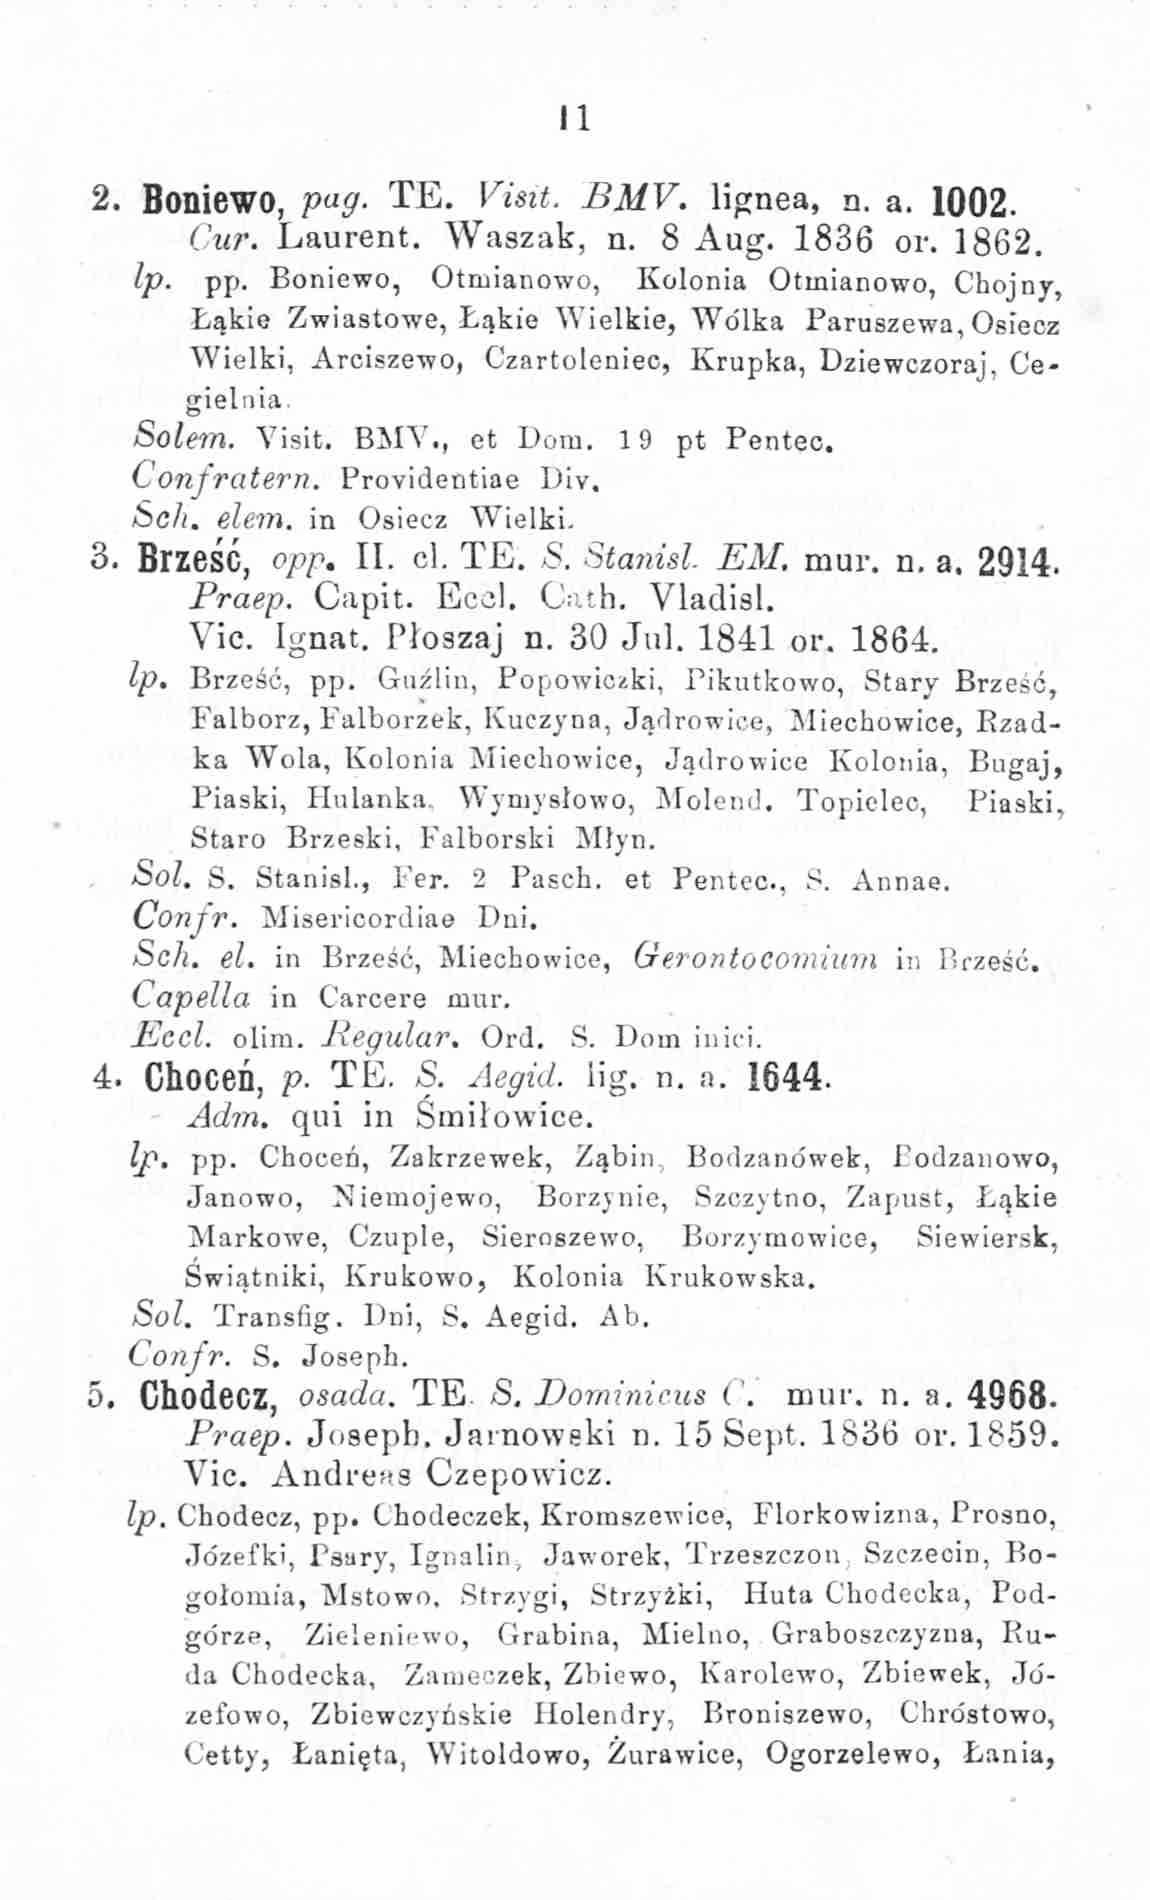
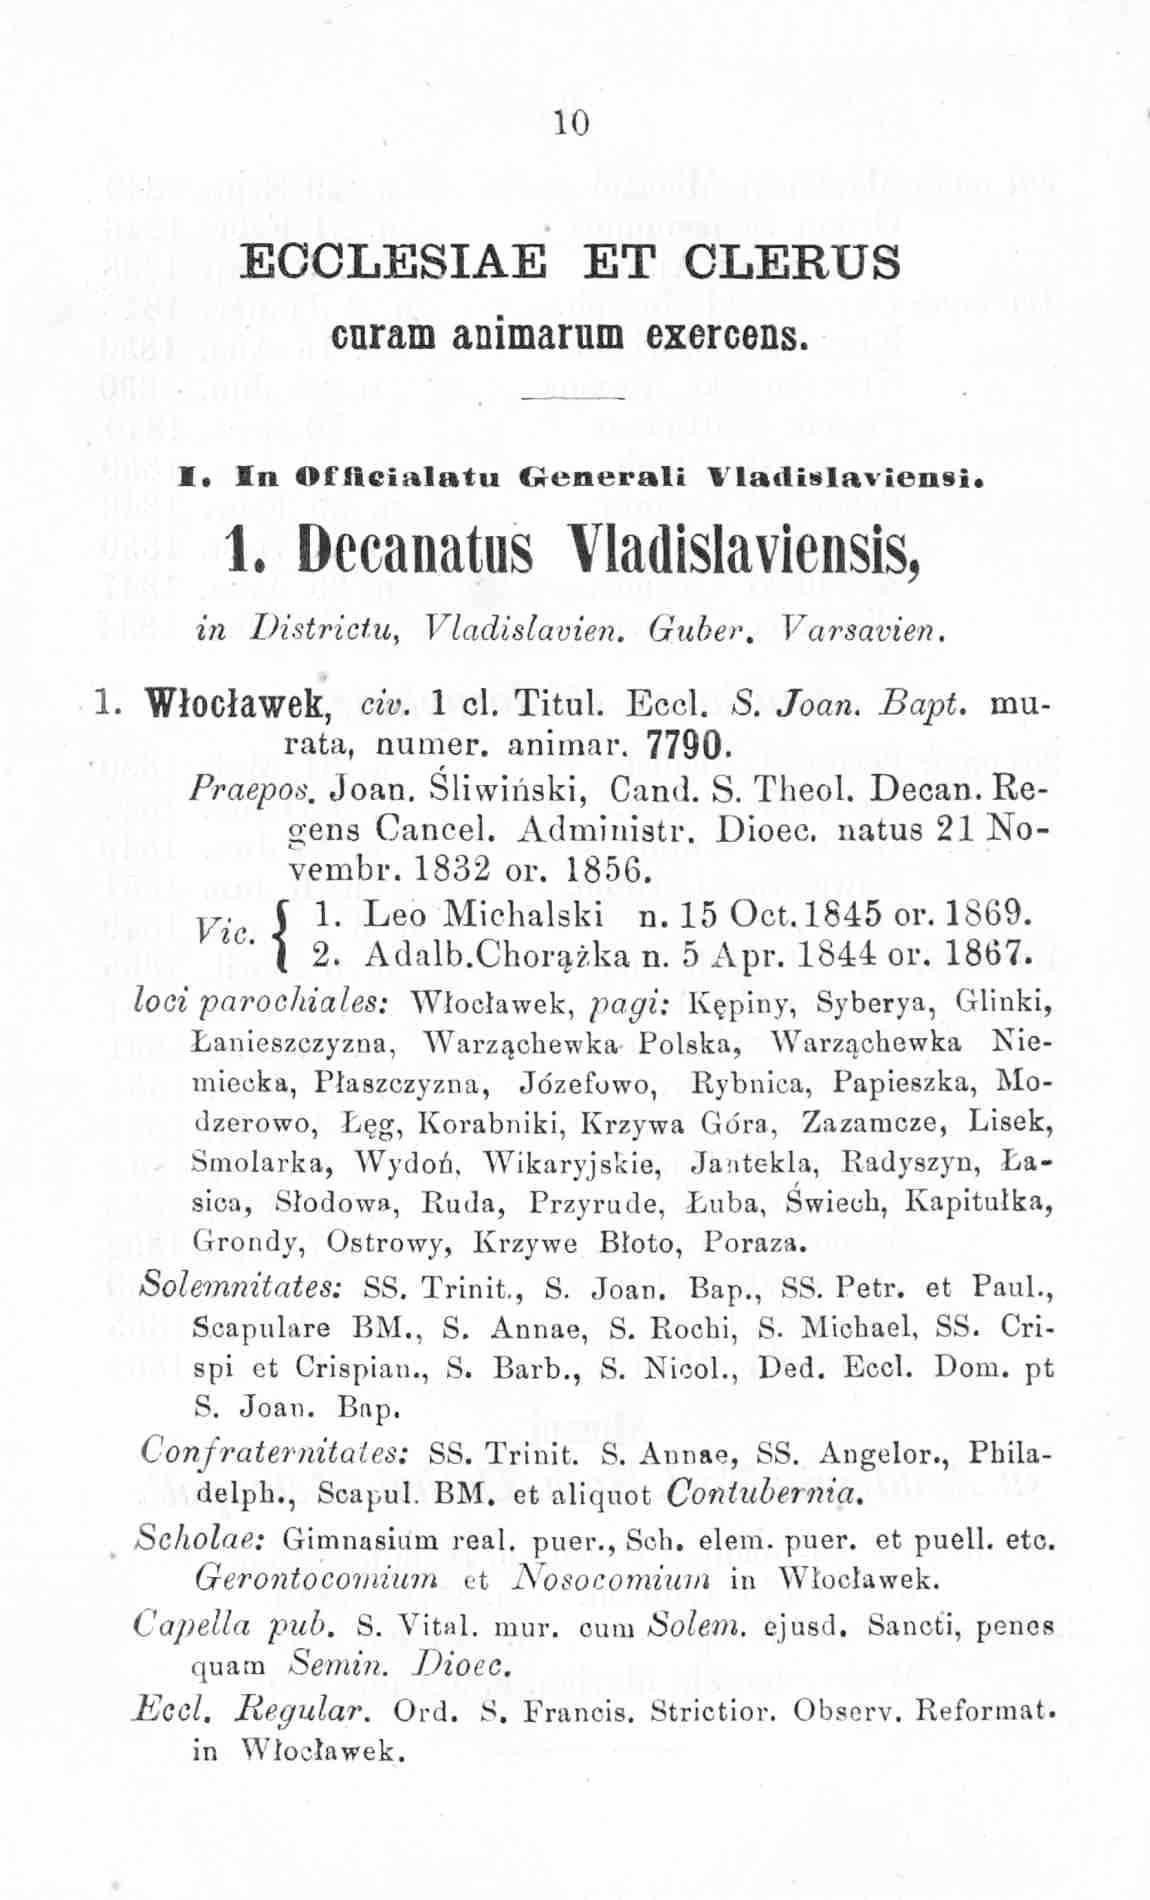

In [34]:
for page in docling_orc_resutl:
    print(page)
    print("-----")


In [27]:
from typing import Dict, List

def sort_pages_safely(doc) -> Dict[str, List]:
    # Get page headers with validation
    page_headers = [t for t in doc.texts if t.label == 'page_header']
    
    # Create physical->logical mapping with error handling
    page_map = {}
    for ph in page_headers:
        try:
            logical = int(ph.text)
            physical = str(ph.prov[0].page_no)  # Use string keys
            if physical in doc.pages:
                page_map[physical] = logical
        except (ValueError, IndexError, KeyError):
            continue  # Or log invalid entries

    # Sort pages while preserving invalid/missing pages
    sorted_pages = []
    for phys_page in sorted(page_map, key=lambda x: page_map[x]):
        sorted_pages.append(doc.pages[phys_page])
    
    # Add pages without headers at end
    remaining = [p for k,p in doc.pages.items() if k not in page_map]
    return sorted_pages 



sorted_pages = sort_pages_safely(docling_orc_resutl)

In [28]:
for page in sorted_pages:
    
    print(page.__dict__)

In [9]:
from document_processing import DocumentProcessor, DocumentSorter

sorter = DocumentSorter(docling_orc_resutl)
sorted_doc = sorter.sort()


AttributeError: 'UnorderedList' object has no attribute 'prov'

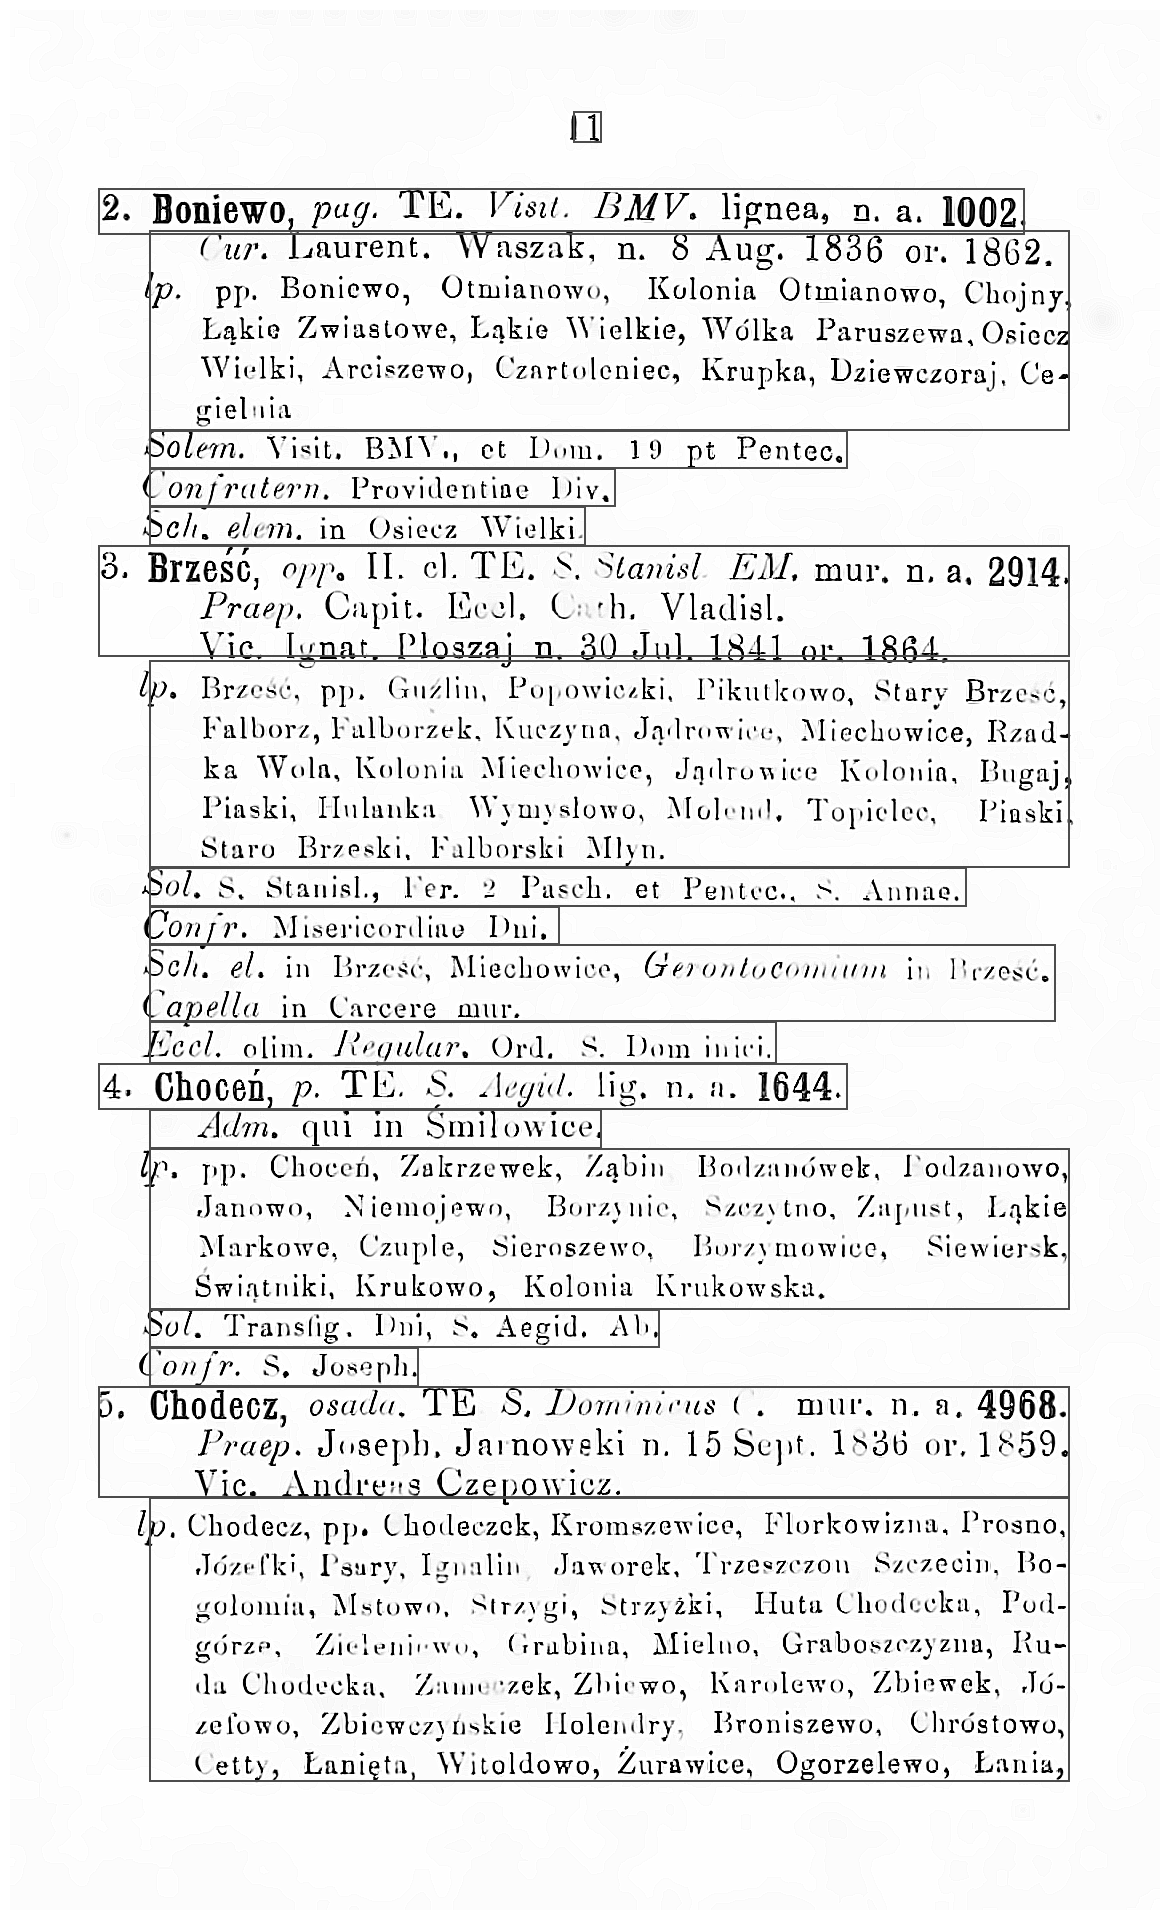

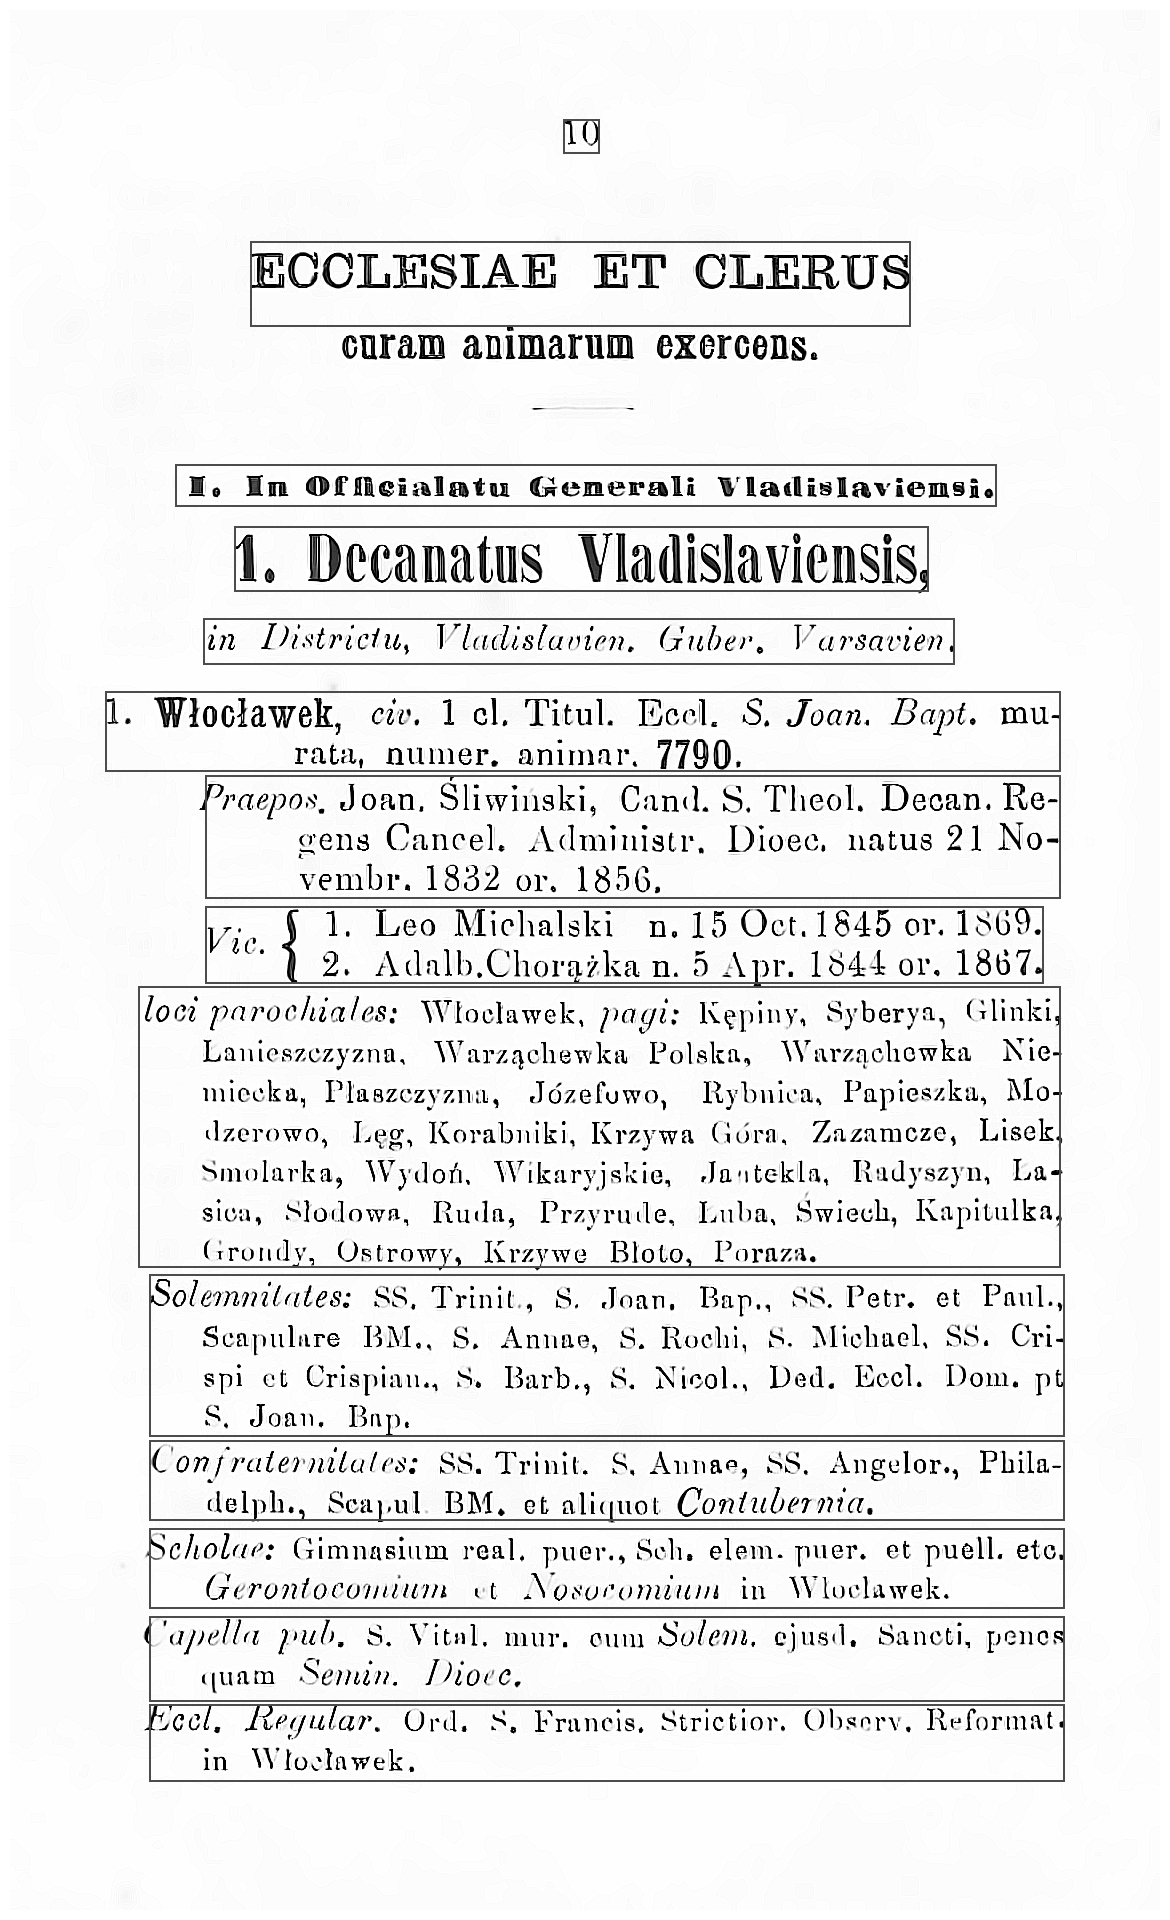

In [24]:
for key, value in rendered_pages.items():
    image = Image.open(BytesIO(value))
    display(image)

In [13]:


#ustawienia doclinga
SHOW_IN_BROWSER = True  #eksportuje output do html i otwiera w przeglądarce

# loading modelu
model_path = "ds4sd/SmolDocling-256M-preview-mlx-bf16"
model, processor = load(model_path)
config = load_config(model_path)

#główny prompt
prompt = "Convert this page to docling."

# Apply chat template
formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)

# Process all images in directory
outputs = []
images = []
for image_index, image_file in enumerate(sorted(os.listdir(ABSOLUTE_IMAGE_DIRECTORY))):
    if not image_file.endswith('.jpg'):
        continue
        
    if image_file != "0010.jpg":
        continue
    image_path = os.path.join(ABSOLUTE_IMAGE_DIRECTORY, image_file)
    print(f"Processing {image_file}")
    with Image.open(image_path) as img:
        images.append(img)

        img = preprocess_for_ocr(img)
        
        # Generate OCR output for each image
        output = ""
        for token in stream_generate(
            model, processor, formatted_prompt, [img], max_tokens=8096, verbose=False
        ):
            output += token.text
            print(token.text, end="")
            if "</doctag>" in token.text:
                break
                
        outputs.append(output)
        print(f"\nProcessed {image_file}\n")


    if image_index > 10:
        break
# Combine all outputs into single document
doctags_doc = DocTagsDocument.from_doctags_and_image_pairs(outputs, images)
doc = DoclingDocument(name="WloclawekSchematyzm1872")
doc.load_from_doctags(doctags_doc)

import webbrowser

out_path = Path("./output.html")
doc.save_as_html(out_path, image_mode=ImageRefMode.EMBEDDED)
webbrowser.open(f"file:///{str(out_path.resolve())}")

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 217234.87it/s]


Processing 0010.jpg
 <doctag><page_header><loc_241><loc_31><loc_256><loc_40>10</page_header>
<section_header_level_1><loc_107><loc_63><loc_389><loc_85>ECOLESIAE ET CLERUS cum animarum exercons.</section_header_level_1>
<section_header_level_1><loc_75><loc_121><loc_426><loc_132>1. In Orbialatu Generali Vladslaviensi.</section_header_level_1>
<section_header_level_1><loc_100><loc_137><loc_397><loc_154>1. Decanatus Vladislaviensis,</section_header_level_1>
<text><loc_87><loc_161><loc_408><loc_173>in I District, Vludislavien. Guber. Varsavien.</text>
<unordered_list><list_item><loc_45><loc_180><loc_453><loc_201>1. Włocławek, civ. 1 cl. Titul. Ecl. S. Joan. Bapt. mu- ratu, numer. animar. 7790.</list_item>
</unordered_list>
<text><loc_88><loc_202><loc_453><loc_234>Praepos. Joan. Śliwiński, Cand. S. Theol. Decan. Re- gens Cancel. Administr. Dioc. natus 21 No- vembir. 1832 or. 1856.</text>
<text><loc_88><loc_236><loc_446><loc_256>Vic. 1. Leo Michalski n. 15 Oct. 1845 or. 1569. 2. Aald. Chorząk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


True

In [2]:
import docling

In [4]:
from docling_core.types import DoclingDocument
# Extract all section headers
section_headers = doc.get_elements("section_header_level_1")
for header in section_headers:
    print(header.text)

# Extract text blocks with bounding boxes
text_blocks = doc.get_elements("text")
for block in text_blocks:
    print(f"Text: {block.text}, Coordinates: {block.metadata['bbox']}")

NameError: name 'doc' is not defined

### Mistral OCR

In [14]:
import os
from mistralai import Mistral

from dotenv import load_dotenv

# Load environment variables from .env file
if not load_dotenv():
    raise RuntimeError("Failed to load .env file")

# Verify API key is available
api_key = os.getenv("MISTRAL_API_KEY")
if not api_key:
    raise ValueError("MISTRAL_API_KEY not found in environment variables")

client = Mistral(api_key=api_key)

ocr_response = client.ocr.process(
    model="mistral-ocr-latest", 
    document={
        "type": "document_url",
        "document_url": "https://arxiv.org/pdf/2201.04234"
    },
    include_image_base64=True
)

In [17]:
print(ocr_response.pages[0].markdown)

# LEVERAGING UNLABELED DATA TO PREDICT OUT-OF-DISTRIBUTION PERFORMANCE 

Saurabh Garg*<br>Carnegie Mellon University<br>sgarg2@andrew.cmu.edu<br>Sivaraman Balakrishnan<br>Carnegie Mellon University<br>sbalakri@andrew.cmu.edu<br>Zachary C. Lipton<br>Carnegie Mellon University<br>zlipton@andrew.cmu.edu

## Behnam Neyshabur

Google Research, Blueshift team
neyshabur@google.com

Hanie Sedghi<br>Google Research, Brain team<br>hsedghi@google.com


#### Abstract

Real-world machine learning deployments are characterized by mismatches between the source (training) and target (test) distributions that may cause performance drops. In this work, we investigate methods for predicting the target domain accuracy using only labeled source data and unlabeled target data. We propose Average Thresholded Confidence (ATC), a practical method that learns a threshold on the model's confidence, predicting accuracy as the fraction of unlabeled examples for which model confidence exceeds that threshold. ATC ou

# Klasy PyDantic dla structured output

In [91]:
from pydantic import BaseModel
import json

from pydantic import BaseModel, Field
from typing import List, Optional, Tuple

class DekanatPrediction(BaseModel):
    """Prediction of deanery."""
    dekanat_name: str = Field(..., description="Name of the deanery.")
    confidence: Optional[float] = Field(description="Prediction confidence.")
    supporting_evidence: List[str] = Field(..., description="Supporting evidence for the prediction.")

class BoundingBox(BaseModel):
    # Załóżmy współrzędne pikselowe
    x_min: int
    y_min: int
    x_max: int
    y_max: int

class FontInfo(BaseModel):
    """Font information, if available from OCR."""
    size: Optional[float]
    is_bold: Optional[bool]
    is_italic: Optional[bool]
    # name: Optional[str] = None # Nazwa czcionki

class StructuralHints(BaseModel):
    """Structural hints obtained from layout/formatting analysis."""
    is_heading: Optional[bool]
    vertical_position_normalized: Optional[float]
    is_list_item: Optional[bool]
    indentation_level: Optional[int]
    detected_keywords: List[str] = [] # Wykryte słowa kluczowe (np. ['Decanatus', 'Titul.', 'murata'])
    previous_element_distance: Optional[int]
    next_element_distance: Optional[int]

class EnhancedTextElement(BaseModel):
    """Enhanced text element from OCR, containing structural hints."""
    text: str = Field(..., description="Recognized text.")
    bbox: BoundingBox = Field(..., description="Position on page.")
    confidence: Optional[float] = Field(description="OCR recognition confidence.")
    font_info: Optional[FontInfo]
    structural_hints: Optional[StructuralHints]
    # Można dodać np. numer linii, numer bloku tekstu, jeśli OCR to zwraca


class StructuredSchematismPage(BaseModel):
    """OCR structure for page, enriched with hints."""
    dekanat_prediction: Optional[DekanatPrediction] = Field(None, description="Deanery prediction.")
    page_number: int
    image_width: Optional[int]
    image_height: Optional[int]
    elements: List[EnhancedTextElement]

json = json.dumps(StructuredSchematismPage.model_json_schema()).replace("'",'"')

In [30]:
json

'{"$defs": {"BoundingBox": {"properties": {"x_min": {"title": "X Min", "type": "integer"}, "y_min": {"title": "Y Min", "type": "integer"}, "x_max": {"title": "X Max", "type": "integer"}, "y_max": {"title": "Y Max", "type": "integer"}}, "required": ["x_min", "y_min", "x_max", "y_max"], "title": "BoundingBox", "type": "object"}, "DekanatPrediction": {"description": "Prediction of deanery.", "properties": {"dekanat_name": {"description": "Name of the deanery.", "title": "Dekanat Name", "type": "string"}, "confidence": {"anyOf": [{"type": "number"}, {"type": "null"}], "default": null, "description": "Prediction confidence.", "title": "Confidence"}, "supporting_evidence": {"description": "Supporting evidence for the prediction.", "items": {"type": "string"}, "title": "Supporting Evidence", "type": "array"}}, "required": ["dekanat_name", "supporting_evidence"], "title": "DekanatPrediction", "type": "object"}, "EnhancedTextElement": {"description": "Enhanced text element from OCR, containing 

In [24]:
sonimport instructor

In [93]:
import instructor
import base64
import os
from mistralai import Mistral
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk


from dotenv import load_dotenv

# Load environment variables from .env file
if not load_dotenv():
    raise RuntimeError("Failed to load .env file")

api_key = os.getenv("MISTRAL_API_KEY")
if not api_key:
    raise ValueError("MISTRAL_API_KEY not found in environment variables")

mistral_client = Mistral(api_key=api_key)
# instructor_client = instructor.from_mistral(client=mistral_client
#                                             mode=Mode.MISTRAL_TOOLS)

def structured_ocr(image_path: str) -> StructuredSchematismPage:
    """
    Process an image using OCR and extract structured data.

    Args:
        image_path: Path to the image file to process

    Returns:
        StructuredOCR object containing the extracted data

    Raises:
        AssertionError: If the image file does not exist
    """
    # Validate input file
    image_file = Path(image_path)
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = mistral_client.ocr.process(
        document=ImageURLChunk(image_url=base64_data_url),
        model="mistral-ocr-latest"
    )
    image_ocr_markdown = image_response.pages[0].markdown

    return image_ocr_markdown

response = structured_ocr("/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/wloclawek_1872/0006.jpg")

In [96]:
with open("wloclawek_1872_0006.md", "w") as f:
    f.write(response)

In [16]:
outputs
images[0].filename.split("/")[-1]

'0071.jpg'